# Using PixieDust for Fast, Flexible, and Easier Data Analysis and Experimentation  

> Interactive notebooks are powerful tools for fast and flexible experimentation and data analysis. Notebooks can contain live code, static text, equations and visualizations. In this lab, you use IBM Data Science Experience to create a notebook to explore and visualize data to gain insight. We will use PixieDust, an open source Python notebook helper library, to visualize the data in different ways (for example, charts, maps, etc.) with one simple call.  

![pixiedust](https://developer.ibm.com/clouddataservices/wp-content/uploads/sites/85/2017/03/pixiedust200.png)

You can access the complete tutorial with step by step instructions <a href="http://ibm.biz/pixiedustlab" target="_blank" rel="noopener no referrer">here.</a>  

This notebook runs on Python with Spark 2.0.

## Table of contents
1. [Import PixieDust](#install)
2. [Load the data](#loaddata)
3. [View and visualize the data](#viewdata)
4. [Map the data](#mapdata)
5. [Summary](#summary)


## 1. Import PixieDust<a class="anchor" id="install"></a>
Before you can use the PixieDust library it must be imported into the notebook.

In [1]:
import pixiedust

Pixiedust database opened successfully


## 2. Load the data<a class="anchor" id="loaddata"></a>
With PixieDust, you can easily load CSV data from a URL into a PySpark DataFrame in the notebook. 
In this example, we load a data set with information about restaurant inspections.

In [2]:
inspections = pixiedust.sampleData("https://opendata.lasvegasnevada.gov/resource/86jg-3buh.csv")

Downloaded 364381 bytes
Creating pySpark DataFrame for 'https://opendata.lasvegasnevada.gov/resource/86jg-3buh.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://opendata.lasvegasnevada.gov/resource/86jg-3buh.csv'


## 3. View and visualize the data<a class="anchor" id="view"></a>
Use PixieDust's **`display`** API to easily view and visualize the data.

3.1 [Filter the data set](#filter)<br/>
3.1 [Visualize the number of restaurants by category](#category)<br/>
3.2 [Visualize average number of inspection demerits per category clustered by the inspection grade](#inspectiongrade)<br/>
3.3 [Visualize current demerits vs inspection demerits](#demerits)

In [3]:
display(inspections)

:@computed_region_tnyv_z3b7,address,category_name,city,current_demerits,current_grade,date_current,employee_id,inspection_date,inspection_demerits,inspection_grade,inspection_result,inspection_time,inspection_type,location_1,location_1_address,location_1_city,location_1_state,location_1_zip,location_name,permit_number,permit_status,record_updated,restaurant_name,serial_number,state,violations,zip
None,4000 W Flamingo Rd,Bar / Tavern,Las Vegas,5,A,2017-08-07 00:00:00,EE7001214,2017-08-07 00:00:00,5,A,'A' Grade,2017-08-07 15:20:00,Routine Inspection,POINT (115.1929046 36.1166353),None,None,None,None,Gold Coast Hotel & Casino,PR0006774,A,2017-08-08 09:31:16,Gold Coast Bingo Service Bar,DA0EHXVCT,Nevada,209,89103-4004
None,1237 Nevada Hwy,Restaurant,Boulder City,5,A,2017-08-08 00:00:00,EE7001020,2017-08-08 00:00:00,5,A,'A' Grade,2017-08-08 08:00:00,Routine Inspection,POINT (114.8491471 35.9716148),None,None,None,None,McDonald's Restaurant,PR0002776,A,2017-08-08 08:52:21,McDonald's Restaurant #7790,DA0J0HTDI,Nevada,"202,2927",89005-1809
None,1592 N Eastern Ave,Snack Bar,Las Vegas,6,A,2017-08-07 00:00:00,EE7001175,2017-08-07 00:00:00,6,A,'A' Grade,2017-08-07 14:35:00,Routine Inspection,POINT (115.1156331 36.188224),None,None,None,None,7-Eleven Food Store #22293 C,PR0003263,A,2017-08-07 15:09:39,7-Eleven #22293 - Deli,DA0WQ53CA,Nevada,"215,2927,2955",89101-1509
None,4000 W Flamingo Rd,Bar / Tavern,Las Vegas,3,A,2017-08-07 00:00:00,EE7001214,2017-08-07 00:00:00,3,A,'A' Grade,2017-08-07 13:20:00,Routine Inspection,POINT (115.1929046 36.1166353),None,None,None,None,Gold Coast Hotel & Casino,PR0006764,A,2017-08-07 16:51:28,Gold Coast Island Bar,DA16C7JRS,Nevada,215,89103-4004
None,5485 W Flamingo Rd,Snack Bar,Las Vegas,6,A,2017-07-24 00:00:00,EE7000674,2017-07-24 00:00:00,6,A,'A' Grade,2017-07-24 09:20:00,Routine Inspection,POINT (115.216013 36.114652),None,None,None,None,SPRING VALLEY MARKET,PR0099163,A,2017-08-08 10:24:52,SPRING VALLEY MARKET SNACK BAR,DA1800421,Nevada,"212,218",89103-3500
None,3700 W Flamingo Rd,Kitchen Bakery,Las Vegas,3,A,2017-08-03 00:00:00,EE7000674,2017-08-03 00:00:00,3,A,'A' Grade,2017-08-03 12:45:00,Routine Inspection,POINT (115.1848942 36.1164467),None,None,None,None,Rio Suites Hotel,PR0005137,A,2017-08-08 10:37:21,Rio Bakery,DA1800433,Nevada,"216,2930",89103-4043
None,3700 W Flamingo Rd,Restaurant,Las Vegas,8,A,2017-08-03 00:00:00,EE7000674,2017-08-03 00:00:00,8,A,'A' Grade,2017-08-03 14:05:00,Routine Inspection,POINT (115.1848942 36.1164467),None,None,None,None,Rio Suites Hotel,PR0005161,A,2017-08-08 11:10:29,Rio Employee Dining Room Bistro,DA1800443,Nevada,"209,218,2930",89103-4043
None,2121 E Craig Rd,Bar / Tavern,North Las Vegas,3,A,2017-08-04 00:00:00,EE7000390,2017-08-04 00:00:00,3,A,'A' Grade,2017-08-04 12:15:00,Routine Inspection,POINT (115.1190876 36.23855),None,None,None,None,Cannery Hotel & Casino,PR0012866,A,2017-08-08 11:24:20,CANNERY Service Bar #2 'Club',DA1800448,Nevada,"2928,2930,2955",89030-3385
None,2121 E Craig Rd,Bar / Tavern,North Las Vegas,0,A,2017-08-04 00:00:00,EE7000390,2017-08-04 00:00:00,0,A,'A' Grade,2017-08-04 12:45:00,Routine Inspection,POINT (115.1190876 36.23855),None,None,None,None,Cannery Hotel & Casino,PR0012860,A,2017-08-08 11:26:31,CANNERY Club Bar,DA1800452,Nevada,2930,89030-3385
None,2595 E CRAIG Rd B,Restaurant,North Las Vegas,9,A,2017-08-07 00:00:00,EE7000390,2017-08-07 00:00:00,9,A,'A' Grade,2017-08-07 12:30:00,Routine Inspection,POINT (115.1147678 36.2395558),None,None,None,None,TOKYO CAFE,PR0113745,A,2017-08-08 11:50:22,TOKYO CAFE,DA1800458,Nevada,"212,213,216,2910,2928,2930",89030


### 3.1 Filter the data set<a class="anchor" id="filter"></a>
Filter the data set to create a subset of only the Las Vegas restaurants.

In [4]:
inspections.registerTempTable("restaurants")
lasDF = sqlContext.sql("SELECT * FROM restaurants WHERE city='Las Vegas'")
lasDF.count()

832

<br/>  
### 3.2 Visualize the number of restaurants by category<a class="anchor" id="category"></a>  

Now display the number of restaurants for each category:

1. Click the **Chart** dropdown menu, then choose **Bar Chart**.
2. From the **Chart Options** dialog:
	1. Drag the **`category_name`** field and drop it into the **Keys** area.
	2. Drag the **`count`** field and drop it into the **Values** area.
	3. Set the **# of Rows to Display** to 1000.
	4. Click **OK**.
3. Click the **Renderer** dropdown menu, then choose **bokeh**.
4. Toggle the **Show Legend** Bar Chart Option to show or hide the legend.



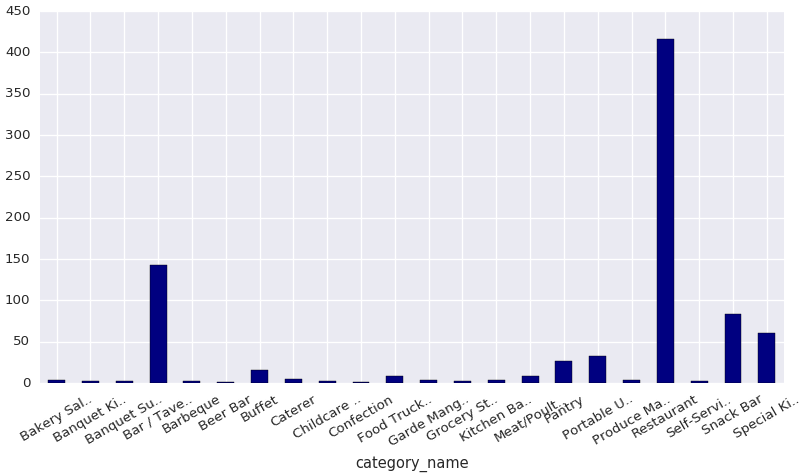

In [5]:
# Number of restaurants by categories

bycat = lasDF.groupBy("category_name").count()
display(bycat)

<br/>  

### 3.3 Visualize the average number of inspection demerits per category clustered by the inspection grade<a class="anchor" id="inspectiongrade"></a>  

1. Click the Chart dropdown menu and choose **Bar Chart**.
2. From the **Chart Options** dialog:
	1. Drag the **`category_name`** field and drop it into the **Keys** area.
	2. Drag the **`inspection_demerits`** field and drop it into the **Values** area.
	3. Set the **Aggregation** to AVG.
	4. Set the **# of Rows to Display** to 1000. 
	5. Click **OK**.
3. Click the **Renderer** dropdown menu and choose **bokeh**.
4. Click the **Cluster By** dropdown menu and choose **inspection_grade**.
5. Click the **Type** dropdown menu and choose the desired bar type, for example, **stacked**.

### 3.4 Visualize current demerits vs inspection demerits <a class="anchor" id="demerits"></a>

1. From the **Chart Options** dialog:
	1. Set the **Keys** to **`inspection_demerits`**.
	2. Set the **Values** to **`current_demerits`**.
	3. Set the **# of Rows to Display** to 1000.
	4. Click **OK**.
2. Click the Chart dropdown menu and choose **Scatter Plot**.
3. Select **bokeh** from the **Renderer** dropdown menu.
4. Select **inspection_grade** from the **Color** dropdown menu.


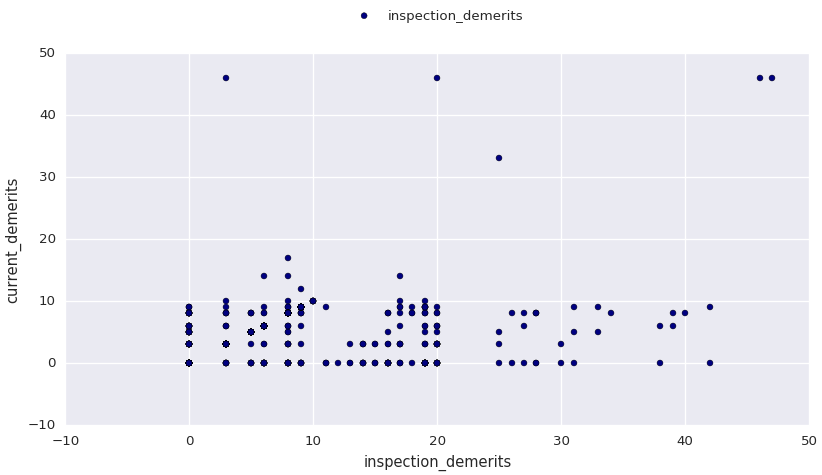

In [6]:
display(lasDF)

## 4. Map the data<a class="anchor" id="mapdata"></a>  

Now visualize the restaurant inspection data together with the restaurant location on a map.

Currently, PixieDust has two map renderers, Google and MapBox and a token is required for the map renderers for them to display correctly. For this section of the tutorial, you use the **MapBox** renderer and you need to create a <a href="https://www.mapbox.com/help/create-api-access-token/" target="_blank" rel="noopener no referrer">MapBox API Access Token</a> if you choose to continue.

4.1 [Create longitude and latitude fields](#longlat)<br/>
4.1 [Display the map](#viewmap)

### 4.1 Create longitude and latitude fields<a class="anchor" id="longlat"></a> 

The current data includes the longitude and latitude in the **`location_1`** field as a string like: `POINT (-114.923505 36.114434)`

However, the current map renderers in PixieDust expect the longitude and latitude as separate number fields, so the first thing you need to do is parse the **`location_1`** field into separate longitude and latitude number fields.

In [7]:
# Parse the location_1 field into separate longitude and latitude number fields

from pyspark.sql.functions import udf
from pyspark.sql.types import *

def valueToLon(value):
    lon = float(value.split('POINT (')[1].strip(')').split(' ')[0])
    return None if lon == 0 else lon if lon < 0 else (lon * -1)

def valueToLat(value):
    lat = float(value.split('POINT (')[1].strip(')').split(' ')[1])
    return None if lat == 0 else lat

udfValueToLon = udf(valueToLon, DoubleType())
udfValueToLat = udf(valueToLat, DoubleType())

lonDF = lasDF.withColumn("lon", udfValueToLon("location_1"))
lonlatDF = lonDF.withColumn("lat", udfValueToLat("location_1"))

lonlatDF.printSchema()

root
 |-- :@computed_region_tnyv_z3b7: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- category_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- current_demerits: integer (nullable = true)
 |-- current_grade: string (nullable = true)
 |-- date_current: timestamp (nullable = true)
 |-- employee_id: string (nullable = true)
 |-- inspection_date: timestamp (nullable = true)
 |-- inspection_demerits: integer (nullable = true)
 |-- inspection_grade: string (nullable = true)
 |-- inspection_result: string (nullable = true)
 |-- inspection_time: timestamp (nullable = true)
 |-- inspection_type: string (nullable = true)
 |-- location_1: string (nullable = true)
 |-- location_1_address: string (nullable = true)
 |-- location_1_city: string (nullable = true)
 |-- location_1_state: string (nullable = true)
 |-- location_1_zip: string (nullable = true)
 |-- location_name: string (nullable = true)
 |-- permit_number: string (nullable = true)
 |-- permit_

<br/>  

### 4.2 Display the map<a class="anchor" id="viewmapdata"></a>  

Now you have separate **`longitude`** and **`latitude`** fields, perform the the following steps to display the data on a map:

1. Click the **Chart** dropdown menu, then choose **Map**.
2. From the **Chart Options** dialog:
	1. Drag the **`lon`** field and the **`lat`** field and drop it into the **Keys** area.
	2. Drag the **`current_demerits`** field and drop it into the **Keys** area.
	3. Set the **# of Rows to Display** to 1000. 
	4. Enter your access token from MapBox into the **MapBox Access Token** field.
	5. Click **OK**.
3. Click the **kind** dropdown menu and choose **choropleth**.


In [8]:
display(lonlatDF)

## 5. Summary<a class="anchor" id="summary"></a>
Using a data set about restaurant inspections, this notebook has introduced you to how you can use a simple PixieDust call to easily  visualize the data in a variety of different ways to provide you with useful insights.

### Author

**Va Barbosa** is an IBM development advocate for IBM Watson and Cloud Platform.

Copyright © IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.